In [2]:
import pandas as pd
import numpy as np
import json
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import xgboost

In [3]:
sns.set_theme(style="whitegrid", palette="pastel")

# INTRODUCTION

In this notebook, I will briefly explore the relationship between a player's rank and their top score rank.<br/>
The player's rank is pretty much self-explanatory, it just means a player's rank at a given time.<br/>
Score rank means the rank that a player has in a specific map. This means that score rank are expected to vary from their actual rank, but as it gets closer to one's best plays, it is going to more closely represent one's actual rank.<br/>
For example, a player of global rank #100 is expected to land #100, not #50. Is this true? If not, what is the trend in the current leaderboard?<br/>
The purpose of this study is to find out the relationship between score ranks and actual rank, and if the result allows, use it to detect alt accounts, or at least filter the ones which look promising.

# EDA

In [4]:
cwd = os.getcwd()
data = pd.read_csv(cwd + '/ScoresTill609.csv')
data.tail()

,Unnamed: 0,rank,pp,playerName,acc1,pp1,scoreRank1,acc2,pp2,scoreRank2,...,scoreRank8,acc9,pp9,scoreRank9,acc10,pp10,scoreRank10,avgTopAcc,avgAcc,avgStars
2995,2995,30324,819.575,/76561199050582734,0.827470,102.8680,451,0.888099,98.6406,9050,...,9553.0,0.820129,62.3921,1535.0,0.815016,52.9063,1495.0,0.816668,0.813065,3.749
2996,2996,30329,819.299,/76561198089462683,0.882350,115.0430,512,0.876950,82.4554,10912,...,7187.0,0.777147,54.3645,45664.0,0.790329,53.6473,12593.0,0.835763,0.679559,3.073
2997,2997,30340,818.972,/76561198156467735,0.935445,116.3840,164,0.847053,109.5260,1281,...,2187.0,0.759411,62.4674,1259.0,0.869447,52.2394,903.0,0.841966,0.772034,3.541
2998,2998,30348,818.596,/76561198410990751,0.863447,81.4211,514,0.830784,71.3074,871,...,1451.0,0.732642,56.2084,1819.0,0.729464,54.1722,2533.0,0.749284,0.737161,3.703
2999,2999,30357,818.266,/76561198044685610,0.913337,115.9460,1626,0.840125,106.7510,5943,...,12850.0,0.830881,61.4375,10743.0,0.695466,50.3369,21688.0,0.821876,0.768421,3.781


So it looks like there are quite a few null values as we proceed down the ranks, meaning that there are people who did not play more than 10 ranked maps. To be specific, let's see how many null numbers the data has.

In [5]:
data.isna().sum()

Unnamed: 0      0
rank            0
pp              0
playerName      0
acc1            0
pp1             0
scoreRank1      0
acc2            0
pp2             0
scoreRank2      0
acc3            0
pp3             0
scoreRank3      0
acc4            0
pp4             0
scoreRank4      0
acc5            1
pp5             1
scoreRank5      1
acc6            1
pp6             1
scoreRank6      1
acc7            6
pp7             6
scoreRank7      6
acc8           15
pp8            15
scoreRank8     15
acc9           27
pp9            27
scoreRank9     27
acc10          45
pp10           45
scoreRank10    45
avgTopAcc       1
avgAcc          1
avgStars        1
dtype: int64

In [6]:
data.dropna(inplace=True, axis = 'rows', subset=['avgTopAcc']) # for rows that did not transfer correctly, there's only one of them, so I felt comfortable just dropping it off

So starting from 5th map, we start to have null values. <br/>
I thought about what I'll do with those values. There are two main strategies that I would like to consider.<br/>
First is a bit tedious, but filling in each columns with appropriate values is one option. For accuracy, we can use average ranked accuracy, and for scoreRank and pp, we can use values that would be given if the average score was given to a average star map.<br/>
Second is just filling them up using backfill, assuming that one's ability must stay approximately the same. Since most of our null values occur after 10000 rankls, I thought using backfill won't hurt that much.<br/>
I will go with the second option for now, since I'm not sure what assumption should be made for people who did not play 10 maps: are they lazy to play 10, or not capable of playing 10 maps?

In [7]:
clean_data = data.fillna(method='backfill', axis = 'columns')

-0.0009264892103455346

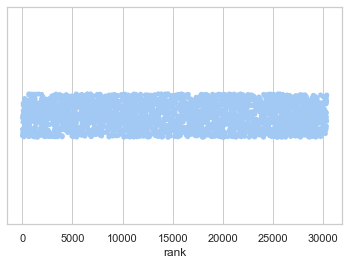

In [8]:
#fig, ax = plt.subplots(1, 2)
sns.stripplot(x = clean_data['rank'])
clean_data['rank'].skew()

It looks like the rank is evenly distributed.

1.3743683897071228

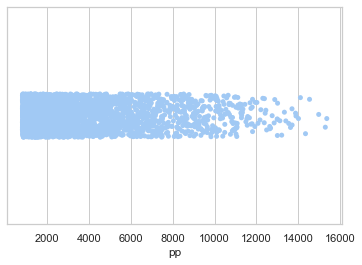

In [9]:
sns.stripplot(x = clean_data['pp'])
clean_data['pp'].skew()

However, the pp is not evenly distributed, it's very much skewed to right. The skewness value of 1.37 indicates that pp is highly skewed.

0.26391393976330285


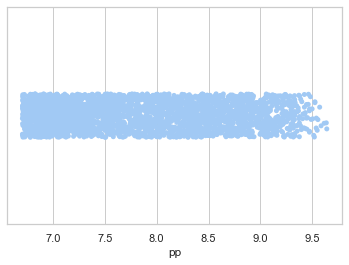

In [10]:
sns.stripplot(x = np.log(clean_data['pp'].astype('float')))
print(np.log(clean_data['pp'].astype('float')).skew())
clean_data['logPP'] = np.log(clean_data['pp'].astype('float'))

Therefore, I decided to take log of the pp data, making it less skewed, although we can still see the skewness(somewhat). The value of 0.26 suggests me that it's still something I can work with in the future. However, the problem with pp is that it is an absolute standard of valuing a player: as time goes on, it does not take into the fact that scores change. Thus, when there is a significant rework or shift in pp, we need to train the model again. However, the ranking is relative to players: it tends to stay similar as time goes on, even if there is a significant shift time.

<AxesSubplot:xlabel='avgTopAcc', ylabel='rank'>

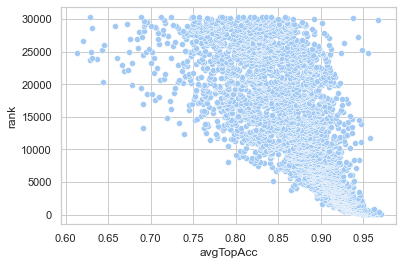

In [11]:
sns.scatterplot(x = clean_data['avgTopAcc'], y = clean_data['rank'])

<AxesSubplot:xlabel='pp1', ylabel='rank'>

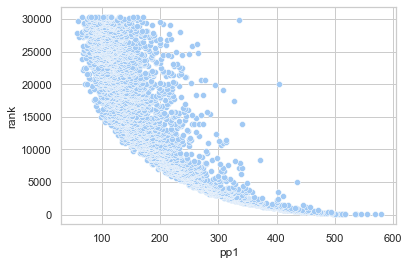

In [12]:
sns.scatterplot(x = clean_data['pp1'], y = clean_data['rank'])

<AxesSubplot:xlabel='avgAcc', ylabel='rank'>

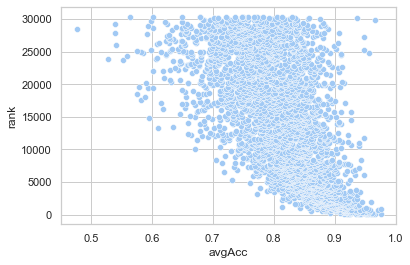

In [13]:
sns.scatterplot(x = clean_data['avgAcc'], y = clean_data['rank'])

<AxesSubplot:xlabel='scoreRank1', ylabel='rank'>

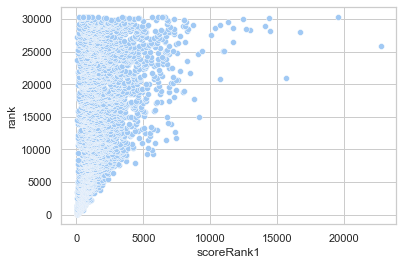

In [14]:
sns.scatterplot(x = clean_data['scoreRank1'], y = clean_data['rank'])

In [15]:
cols_to_use = ['acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'acc6', 'acc7', 'acc8', 'acc9', 'acc10', 'avgStars']
#cols_to_use = ['pp1', 'pp2', 'pp3', 'pp4', 'avgTopAcc', 'avgStars']
#cols_to_use = ['scoreRank1', 'scoreRank2', 'scoreRank3', 'scoreRank4', 'avgTopAcc', 'avgStars']

X_acc = clean_data[cols_to_use].astype('float')
y_acc = clean_data['pp'].astype('float')
X_train, X_valid, y_train, y_valid = train_test_split(X_acc, y_acc)

For the accuracy columns, I'll drop the avgTopAcc feature since it's just a mean of acc1 ~ 10.

Median Absolute Error = 208.47337890624976
Mean Absolute Scaled Error = 0.11531800013006138


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

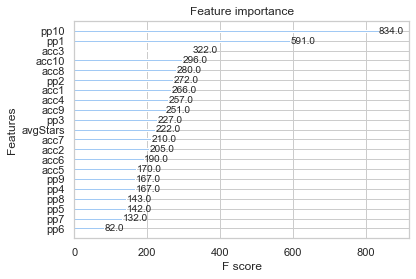

In [23]:
model = xgboost.XGBRegressor(n_estimators = 1300, learning_rate = 0.05, n_jobs = 6, early_stopping_rounds = 5)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

predictions = model.predict(X_valid)
print("Median Absolute Error = {}".format(sklearn.metrics.median_absolute_error(predictions, y_valid)))
print("Mean Absolute Scaled Error = {}".format(sklearn.metrics.mean_absolute_percentage_error(predictions, y_valid)))

xgboost.plot_importance(model)

In [17]:
#cols_to_use = ['acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'acc6', 'acc7', 'acc8', 'acc9', 'acc10', 'avgStars']
cols_to_use = ['pp1', 'pp2', 'pp3', 'pp4', 'pp5', 'pp6', 'pp7', 'pp8', 'pp9', 'pp10', 'avgTopAcc', 'avgStars']
#cols_to_use = ['scoreRank1', 'scoreRank2', 'scoreRank3', 'scoreRank4', 'avgTopAcc', 'avgStars']
X_pp = clean_data[cols_to_use].astype('float')
y_pp = clean_data['pp'].astype('float')
X_train, X_valid, y_train, y_valid = train_test_split(X_pp, y_pp)

Median Absolute Error = 195.64678710937483
Mean Absolute Scaled Error = 0.11489188336581586


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

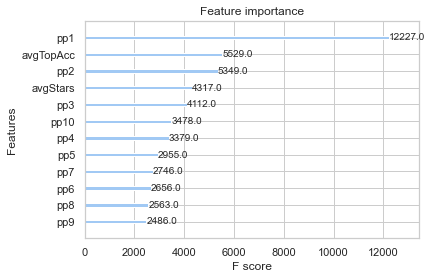

In [18]:
model = xgboost.XGBRegressor(n_estimators = 1500, learning_rate = 0.05, n_jobs = 6)
model.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], verbose = False)

predictions = model.predict(X_valid)
print("Median Absolute Error = {}".format(sklearn.metrics.median_absolute_error(predictions, y_valid)))
print("Mean Absolute Scaled Error = {}".format(sklearn.metrics.mean_absolute_percentage_error(predictions, y_valid)))

xgboost.plot_importance(model)

In [19]:
#cols_to_use = ['acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'acc6', 'acc7', 'acc8', 'acc9', 'acc10', 'avgStars']
#cols_to_use = ['pp1', 'pp2', 'pp3', 'pp4', 'pp5', 'pp6', 'avgTopAcc', 'avgStars']
#cols_to_use = ['scoreRank1', 'scoreRank2', 'scoreRank3', 'scoreRank4', 'avgTopAcc', 'avgStars']
cols_to_use = []
for i in range(1, 11):
    cols_to_use.append('pp{}'.format(i))
    cols_to_use.append('acc{}'.format(i))
cols_to_use.append('avgStars')
X_mixed = clean_data[cols_to_use].astype('float')
y_mixed = clean_data['pp'].astype('float')
X_train, X_valid, y_train, y_valid = train_test_split(X_mixed, y_mixed, test_size = 0.2)

Median Absolute Error = 217.19422607421916
Mean Absolute Scaled Error = 0.11637967932524175


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

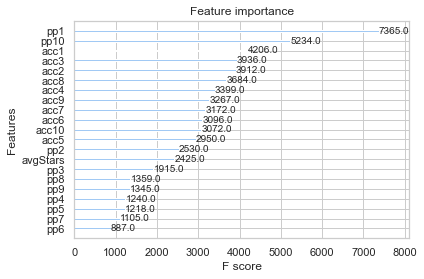

In [20]:
model = xgboost.XGBRegressor(n_estimators = 1500, learning_rate = 0.01, n_jobs = 6)
model.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], verbose = False)

predictions = model.predict(X_valid)
print("Median Absolute Error = {}".format(sklearn.metrics.median_absolute_error(predictions, y_valid)))
print("Mean Absolute Scaled Error = {}".format(sklearn.metrics.mean_absolute_percentage_error(predictions, y_valid)))

xgboost.plot_importance(model)

Along with these mixtures feature selection, the best result that I could get was by using accuracy and pp. Also, as I used XGBoost which utilizes decision tree model, I assumed that it would be robust to the skewness of the raw pp data, so I let the target be pp, not rank or logPP.

So, how does this model help filtering out possible suspicious accounts, from pool of seemingly legit accounts?

Suppose there is an account that has scores set. Using this model, we can generate a prediction of the actual rank that a player is expected to have.
When the prediction is off by a lot, it means that there is something that distinguishes the player from other players: they might be excelling at certain maps that their actual rank is way lower than their performance on top maps, or they might be smurfing. Either way, it means their top 10 plays are **special**.

Of course, this isn't an evidence or something like that, it is a mere signal that the player might be suspicious, and might require further inspection by members of the community who are willing to do so.

In [21]:
test_data = pd.read_csv(cwd + '/ScoresTill11cn.csv')
clean_test_data = test_data.fillna(method='backfill', axis = 'columns')
X_test = clean_test_data[cols_to_use].astype('float')
y_test = (clean_test_data['pp'].astype('float'))
predictions = model.predict(X_test)
result = pd.DataFrame(columns = ['name', 'pp', 'prediction', 'diff'])
result['name'] = test_data['playerName']
result['pp'] = (clean_test_data['pp'].astype('float'))
result['prediction'] = predictions
result['diff'] = result['prediction'] - result['pp']
result = result.sort_values(by=['diff'], ascending = False)
result.to_csv(cwd + '/results.csv', index = True, columns = result.columns, float_format = '%.6f', na_rep = 'NULL')


count     500.000000
mean       58.738874
std       362.030310
min      -918.820703
25%      -154.455793
50%        66.772136
75%       271.193809
max      2169.242832
Name: diff, dtype: float64

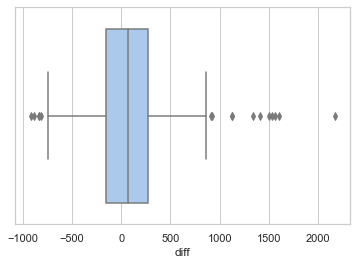

In [22]:
sns.boxplot(x = result['diff'])
result['diff'].skew()
result['diff'].describe()

So now I have two values: a player's actual pp, and a speculation about one's pp given the first 10 songs in their top pp list. 

I ran a brief test of how the model does to a set of country, and I arbitrarily picked China as test case, as it had acceptable amount of people above 600PP range which I trained my model against, but wasn't so large that it only took moderate amount of time to gather the data.

It seems that the diffrence is mostly spread out in 0. In the boxplot we can see few outliers. For values less than 0, we do not need to worry about the values, since that means our speculation is less than their actual pp: yes, it means it's strange, but not strange in a way that interests us. What interests us are the values that excel most of its colleagues. 

Below are the accounts that had overwhelmingly high deviation from its actual pp.

scoresaber.com/u/76561199086770784<br/>
scoresaber.com/u/76561199174553660<br/>
scoresaber.com/u/76561198862765391<br/>
scoresaber.com/u/76561198288980872<br/>
scoresaber.com/u/76561198213511908<br/>
scoresaber.com/u/76561198104067856<br/>
scoresaber.com/u/76561197960376132<br/>
scoresaber.com/u/76561198295521137<br/>
scoresaber.com/u/76561198851314231<br/>
scoresaber.com/u/76561198206592639<br/>
scoresaber.com/u/76561199164128417<br/>
scoresaber.com/u/76561199022121596<br/>
scoresaber.com/u/76561199096398609<br/>

There are few factors that distinguishes suspicious accounts and genuine accounts from each other. However, that is something that should be discussed and I'm not sure if I can take that into account into this, unless I label all the accounts to suspicious ones and genuine ones so I can run a categorization model with the same dataset.

# CONCLUSION

As one can observe from the results, there are players who definitely show strange behaviors. They can be considered as ones having excellent talents who can play top-class maps with top performance from the beginning, but some of them are rather suspicious. 

Although this tool still lacks ability to distinguish those, it does filter out suspicious accounts, and makes the process of manually going through the entire leaderboard much easier.

I will further work on automating the process to desired leaderboard: skip the process of manually picking accounts that have high deviation from its actual pp, and running it once every day or two. As this model is towards filtering out players who shows drastic increase of skill level compared to their usual skill level, it would be less effective if it was used every month or in a longer timeframe. 

Furthermore, this model cannot filter ones that show normal progression of skills. If a alt account decides to build their scores bottom to top, slowly increasing their top pp maps and rank accordingly, it will fail to classify it as suspicious. 

Any advice and recommendations are welcome. 